In [1]:
from vivarium import Artifact
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from db_queries import get_ids, get_outputs
import scipy.stats

!whoami
!date

alibow
Mon Jun 29 10:33:10 PDT 2020


In [2]:
# add list here when complete :) 

output_dirs = ['/share/costeffectiveness/results/vivarium_conic_lsff/india/2020_06_26_20_35_00/count_data/',
              '/share/costeffectiveness/results/vivarium_conic_lsff/nigeria/2020_06_26_20_28_27/count_data/']

locations = ['India','Nigeria']

In [3]:
def get_stratified_averted_results(strata_cols):
    master_data = pd.DataFrame()
    master_pt = pd.DataFrame()
    for i in range(len(output_dirs)):
        data = pd.DataFrame()
        for measure in ['deaths','ylls','ylds']:
            temp = pd.read_hdf(output_dirs[i] + measure + '.hdf')
            temp['measure'] = measure
            data = data.append(temp)
        data['location'] = locations[i]
        master_data = master_data.append(data)
        pt = pd.read_hdf(output_dirs[i] + 'state_person_time.hdf')
        pt = pt.loc[pt.cause.str.contains('diarrheal')]
        pt['location'] = locations[i]
        master_pt = master_pt.append(pt)
    master_data = master_data.groupby((['location','scenario','input_draw'] + strata_cols + ['measure'])).sum()
    if 'cause' in strata_cols:
        no_cause_strata_cols = [col for col in strata_cols if col != 'cause']
        master_pt = master_pt.groupby(['location','scenario','input_draw'] + no_cause_strata_cols).sum()
    else:    
        master_pt = master_pt.groupby((['location','scenario','input_draw'] + strata_cols)).sum()
    rates = master_data / master_pt
    baseline_rates = rates.reset_index()
    baseline_rates = baseline_rates.loc[baseline_rates.scenario == 'baseline']
    baseline_rates = baseline_rates.set_index((['location','input_draw'] + strata_cols + ['measure'])).drop(columns='scenario')
    rates = rates.reset_index().set_index((['location','input_draw'] + strata_cols + ['measure','scenario']))
    averted_rates = (baseline_rates - rates) * 100_000
    averted_rates = averted_rates.reset_index()
    averted_rates = averted_rates.loc[averted_rates.scenario != 'baseline']
    return averted_rates

In [4]:
overall = get_stratified_averted_results([])
overall.head()

,location,input_draw,measure,scenario,value
1,India,21,deaths,folic_acid_fortification_scale_up,0.000000
2,India,21,deaths,iron_folic_acid_fortification_scale_up,0.000000
3,India,21,deaths,vitamin_a_fortification_scale_up,2.251110
5,India,21,ylds,folic_acid_fortification_scale_up,0.005643
6,India,21,ylds,iron_folic_acid_fortification_scale_up,11.787625


In [5]:
np.unique(overall['location'])

array(['India', 'Nigeria'], dtype=object)

In [6]:
by_year = get_stratified_averted_results(['year'])
by_year.head()

,location,input_draw,year,measure,scenario,value
1,India,21,2020,deaths,folic_acid_fortification_scale_up,1.734723e-13
2,India,21,2020,deaths,iron_folic_acid_fortification_scale_up,2.602085e-13
3,India,21,2020,deaths,vitamin_a_fortification_scale_up,1.734723e-13
5,India,21,2020,ylds,folic_acid_fortification_scale_up,6.938894e-13
6,India,21,2020,ylds,iron_folic_acid_fortification_scale_up,2.081668e-12


In [7]:
by_cause = get_stratified_averted_results(['cause'])
by_cause.head()

,location,input_draw,cause,measure,scenario,value
1,India,21,diarrheal_diseases,deaths,folic_acid_fortification_scale_up,0.000000e+00
2,India,21,diarrheal_diseases,deaths,iron_folic_acid_fortification_scale_up,0.000000e+00
3,India,21,diarrheal_diseases,deaths,vitamin_a_fortification_scale_up,1.510158e+00
5,India,21,diarrheal_diseases,ylds,folic_acid_fortification_scale_up,-2.168404e-14
6,India,21,diarrheal_diseases,ylds,iron_folic_acid_fortification_scale_up,2.168404e-14


In [8]:
np.unique(by_cause['cause'])

array(['diarrheal_diseases', 'iron_deficiency',
       'lower_respiratory_infections', 'measles', 'neural_tube_defects',
       'other_causes', 'vitamin_a_deficiency'], dtype=object)

In [9]:
def plot_results_by_cause(dataset, scenarios, outcome_vars, causes):
    for scenario in scenarios:
        for cause in causes:
            for outcome_var in outcome_vars:
                
                if outcome_var == 'dalys':
                    outcome_name_long = 'Disability Adjusted Life Years'
                    outcome_name_short = 'DALYs'
                elif outcome_var == 'ylls':
                    outcome_name_long = 'Years of Life Lost'
                    outcome_name_short = 'YLLs'
                elif outcome_var == 'ylds':
                    outcome_name_long = 'Years Lived with Disability'
                    outcome_name_short = 'YLDs'
                else:
                    outcome_name_long = 'Deaths'
                    outcome_name_short = 'Deaths'
                
                data = dataset.loc[dataset.scenario == scenario]
                data = data.loc[data.cause == cause]
                
                if outcome_var == 'dalys':
                    data = data.loc[data.measure.isin(['ylls','ylds'])]
                    data = data.groupby(['location','input_draw']).sum()
                else:
                    data = data.loc[data.measure == outcome_var]
                
                data = data.groupby(['location']).describe().reset_index().set_index('location')

                pos1 = 0.2
                pos2 = 0.4
                pos3 = 0.6    

                fig, ax = plt.subplots(figsize=(7.5, 5))

                plt.plot([(pos1 - 0.1),(pos3 + 0.1)],[0,0],'--',c='grey')

                plt.plot([pos1,pos1],[data['value','min'][0],data['value','max'][0]],c='black')
                plt.plot([pos2,pos2],[data['value','min'][1],data['value','max'][1]],c='black')
                #plt.plot([pos3,pos3],[data['value','min'][2],data['value','max'][2]],c='black')
                #plt.scatter([pos1,pos2,pos3],data['value','min'], marker='_',c='black',s=50)
                #plt.scatter([pos1,pos2,pos3],data['value','max'], marker='_',c='black',s=50)         
                #plt.scatter([pos1,pos2,pos3],data['value','mean'], s=100)

                #rewritten for india and nigeria only
                plt.scatter([pos1,pos2],data['value','min'], marker='_',c='black',s=50)
                plt.scatter([pos1,pos2],data['value','max'], marker='_',c='black',s=50)         
                plt.scatter([pos1,pos2],data['value','mean'], s=100)

                scenario_title = scenario.replace('_',' ').capitalize()
                cause_title = cause.replace('_',' ').capitalize()

                plt.xticks([pos1,pos2,pos3], data.index)
                if outcome_var == 'deaths':
                    plt.title(f'{scenario_title}\n{outcome_name_long} due to {cause_title} Averted per 100,000 Person-Years')
                else:
                    plt.title(f'{scenario_title}\n{outcome_name_long} ({outcome_name_short}) due to {cause_title}\n Averted per 100,000 Person-Years')
                plt.ylabel(f'{outcome_name_short} Averted per 100,000 PY')

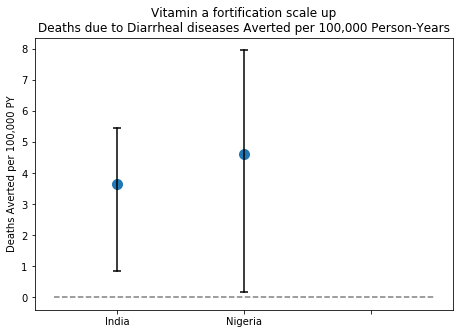

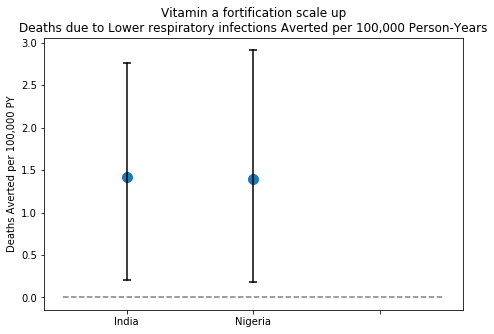

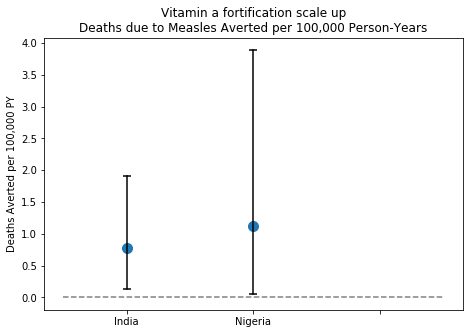

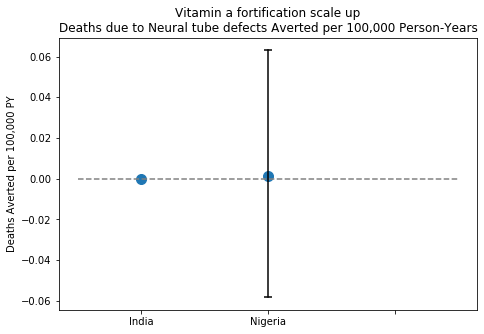

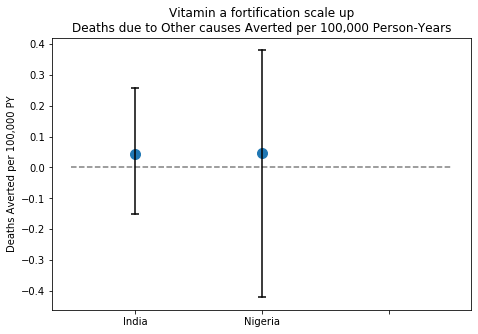

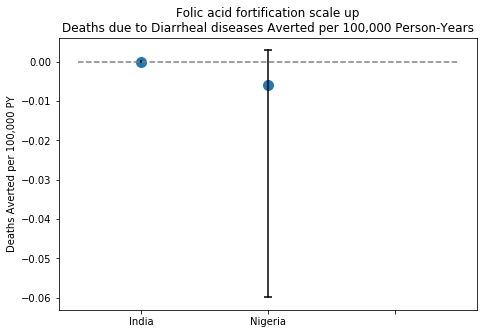

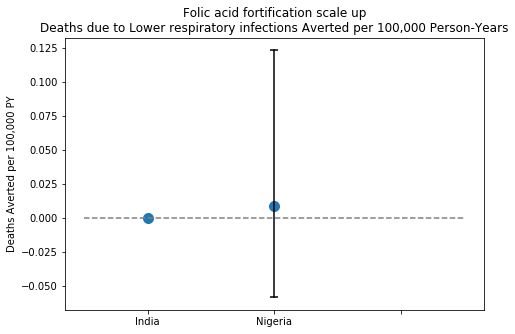

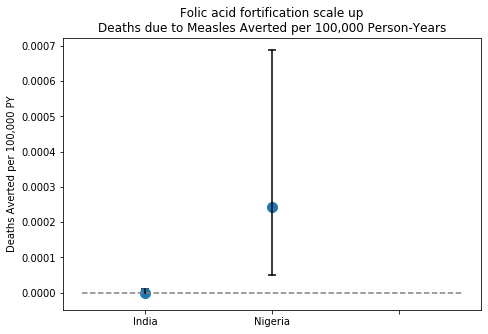

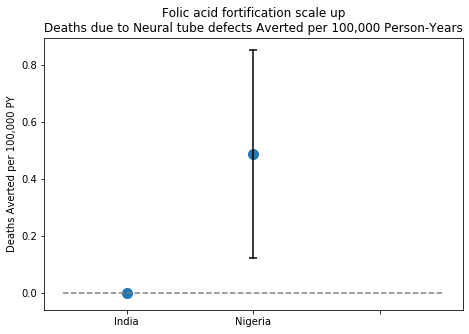

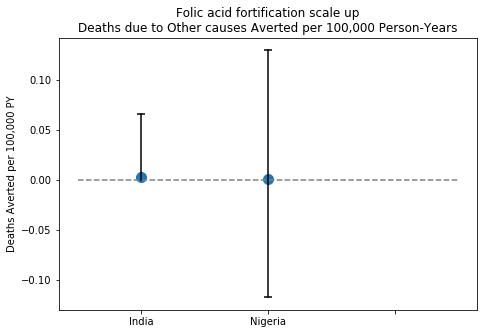

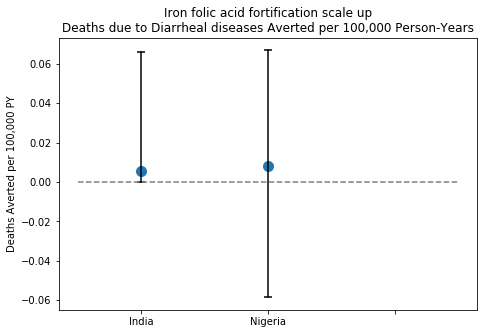

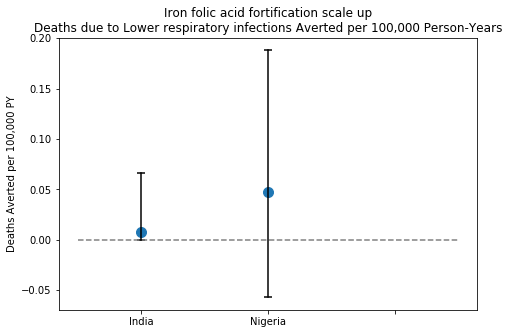

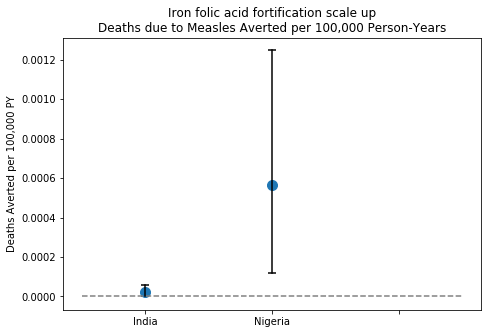

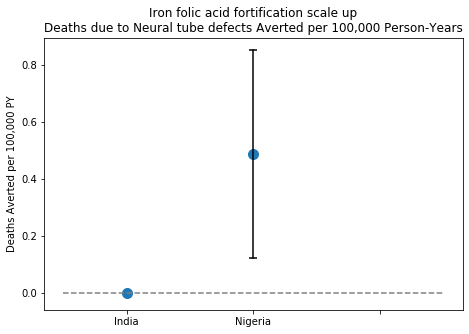

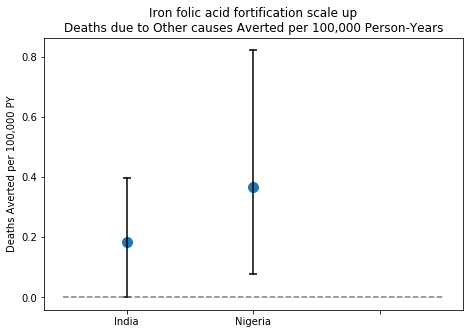

In [10]:
# fatal causes

scenarios = ['vitamin_a_fortification_scale_up','folic_acid_fortification_scale_up','iron_folic_acid_fortification_scale_up']

outcome_vars = ['deaths']

causes = ['diarrheal_diseases',
       'lower_respiratory_infections', 'measles', 'neural_tube_defects',
       'other_causes']

plot_results_by_cause(by_cause, scenarios, outcome_vars, causes)

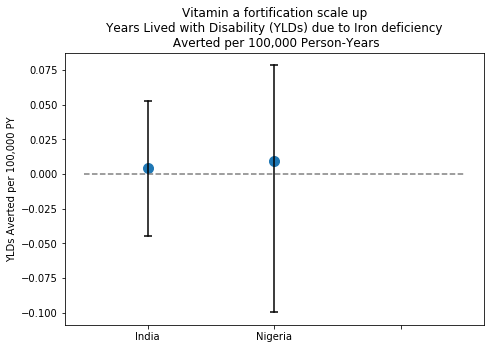

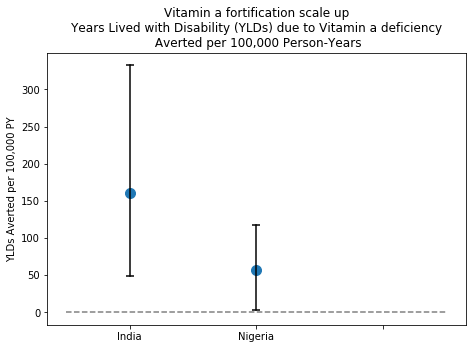

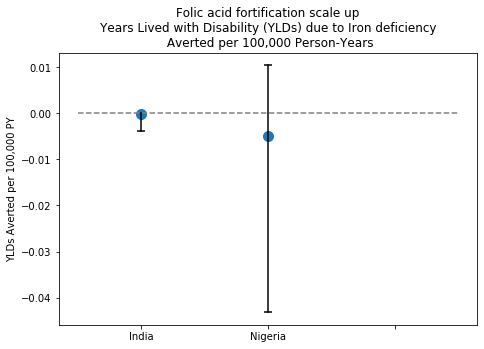

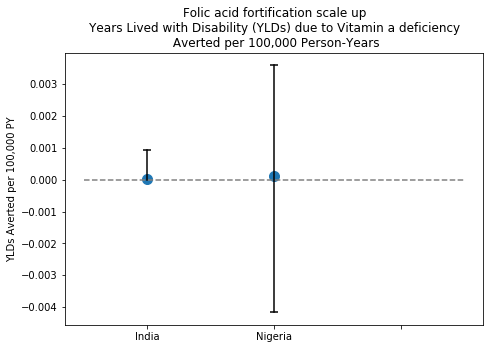

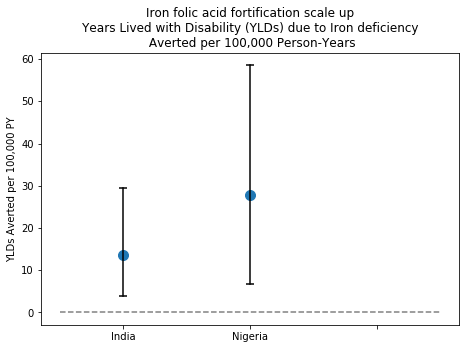

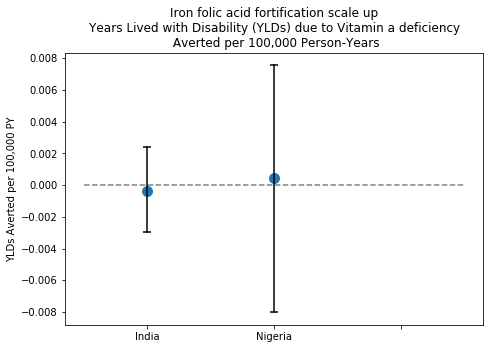

In [11]:
# non-fatal causes

scenarios = ['vitamin_a_fortification_scale_up','folic_acid_fortification_scale_up','iron_folic_acid_fortification_scale_up']

outcome_vars = ['ylds']

causes = ['iron_deficiency','vitamin_a_deficiency']

plot_results_by_cause(by_cause, scenarios, outcome_vars, causes)

In [12]:
def make_multiple_plots_by_year_no_uncertainty(dataset, scenarios, outcome_vars):
    for scenario in scenarios:
        for outcome_var in outcome_vars:
            if outcome_var == 'dalys':
                outcome_name_long = 'Disability Adjusted Life Years'
                outcome_name_short = 'DALYs'
            elif outcome_var == 'ylls':
                outcome_name_long = 'Years of Life Lost'
                outcome_name_short = 'YLLs'
            elif outcome_var == 'ylds':
                outcome_name_long = 'Years Lived with Disability'
                outcome_name_short = 'YLDs'
            else:
                outcome_name_long = 'Deaths'
                outcome_name_short = 'Deaths'

            data = dataset.loc[dataset.scenario == scenario]
            if outcome_var == 'dalys':
                data = data.loc[data.measure.isin(['ylds','ylls'])]
                data = data.groupby(['location','year','input_draw'], as_index=False).sum()
            else:
                data = data.loc[data.measure == outcome_var]
            data = data.groupby(['location','year'], as_index=False).mean()

            ethiopia = data.loc[data.location == 'Ethiopia']
            india = data.loc[data.location == 'India']
            nigeria = data.loc[data.location == 'Nigeria']

            fig, ax = plt.subplots(figsize=(7.5, 5))
            
            plt.scatter(ethiopia['year'], ethiopia['value'])
            plt.plot(ethiopia['year'], ethiopia['value'])

            plt.scatter(india['year'], india['value'])
            plt.plot(india['year'], india['value'])

            plt.scatter(nigeria['year'], nigeria['value'])
            plt.plot(nigeria['year'], nigeria['value'])
            
            scenario_title = scenario.replace('_',' ').capitalize()

            plt.title(f'{scenario_title}\n{outcome_name_long} ({outcome_name_short}) Averted per 100,000 Person-Years')
            plt.legend(['Ethiopia','India','Nigeria'])
            plt.ylabel(f'{outcome_name_short} Averted per 100,000 PY')
            #plt.savefig('ethiopia_and_nigeria_by_year.png')

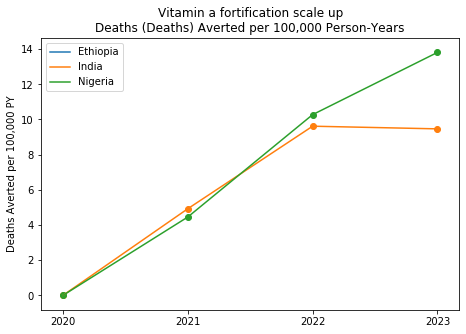

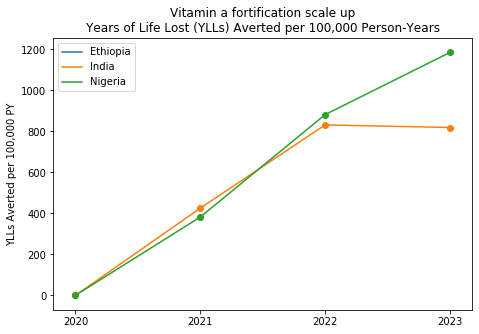

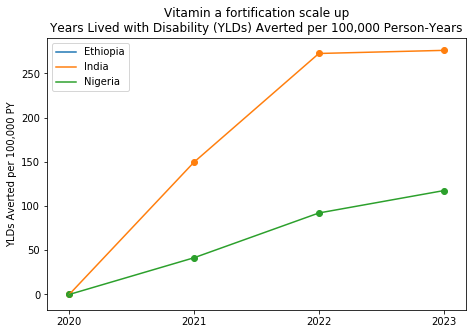

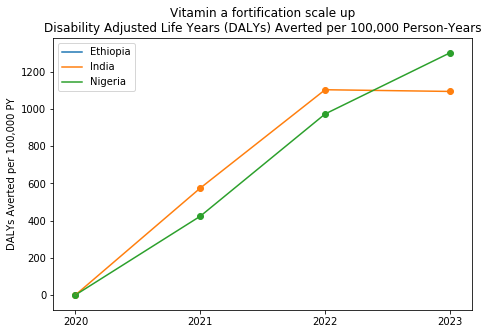

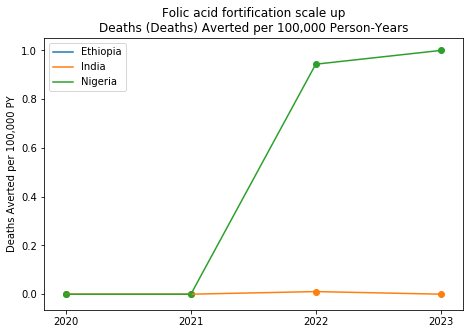

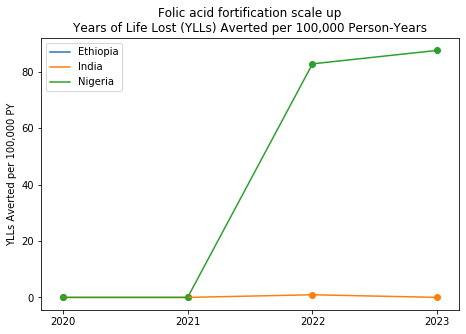

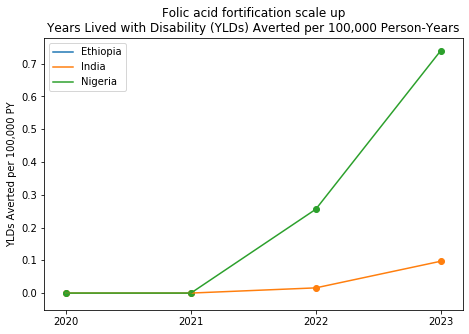

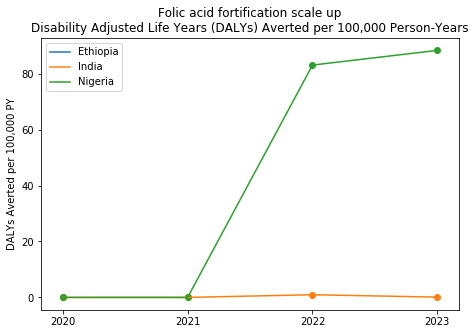

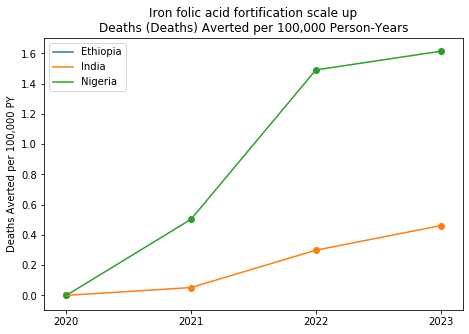

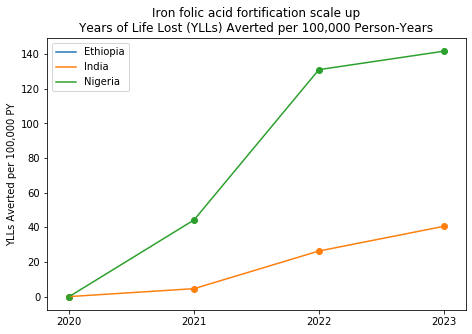

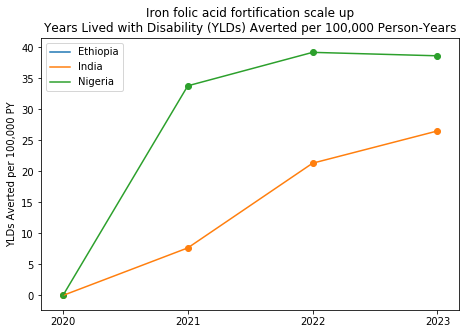

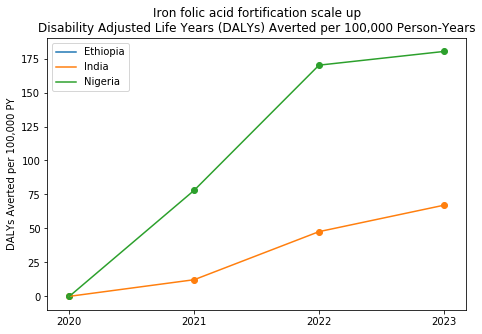

In [16]:
scenarios = ['vitamin_a_fortification_scale_up','folic_acid_fortification_scale_up',
            'iron_folic_acid_fortification_scale_up']

outcome_vars = ['deaths','ylls','ylds','dalys']

make_multiple_plots_by_year_no_uncertainty(by_year, scenarios, outcome_vars)

In [31]:
def make_multiple_plots_by_year_with_uncertainty(dataset, scenarios, outcome_vars):
    for scenario in scenarios:
        for outcome_var in outcome_vars:
            if outcome_var == 'dalys':
                outcome_name_long = 'Disability Adjusted Life Years'
                outcome_name_short = 'DALYs'
            elif outcome_var == 'ylls':
                outcome_name_long = 'Years of Life Lost'
                outcome_name_short = 'YLLs'
            elif outcome_var == 'ylds':
                outcome_name_long = 'Years Lived with Disability'
                outcome_name_short = 'YLDs'
            else:
                outcome_name_long = 'Deaths'
                outcome_name_short = 'Deaths'

            data = dataset.loc[dataset.scenario == scenario]
            if outcome_var == 'dalys':
                data = data.loc[data.measure.isin(['ylds','ylls'])]
                data = data.groupby(['location','year','input_draw'], as_index=False).sum()
            else:
                data = data.loc[data.measure == outcome_var]
            data = data.groupby(['location','year']).describe().reset_index()

            ethiopia = data.loc[data.location == 'Ethiopia']
            india = data.loc[data.location == 'India']
            nigeria = data.loc[data.location == 'Nigeria']

            fig, ax = plt.subplots(figsize=(7.5, 5))
            
            plt.scatter(ethiopia['year'], ethiopia['value','mean'])
            plt.plot(ethiopia['year'], ethiopia['value','mean'])

            plt.scatter(india['year'], india['value','mean'])
            plt.plot(india['year'], india['value','mean'])

            plt.scatter(nigeria['year'], nigeria['value','mean'])
            plt.plot(nigeria['year'], nigeria['value','mean'])
            
            plt.fill_between(ethiopia['year'],ethiopia['value','max'],ethiopia['value','min'], alpha=0.3,color='tab:blue')
            plt.fill_between(india['year'],india['value','max'],india['value','min'], alpha=0.3,color='tab:orange')
            plt.fill_between(nigeria['year'],nigeria['value','max'],nigeria['value','min'], alpha=0.3,color='tab:green')
            
            scenario_title = scenario.replace('_',' ').capitalize()

            plt.title(f'{scenario_title}\n{outcome_name_long} ({outcome_name_short}) Averted per 100,000 Person-Years')
            plt.legend(['Ethiopia','India','Nigeria'])
            plt.ylabel(f'{outcome_name_short} Averted per 100,000 PY')
            #plt.savefig('ethiopia_and_nigeria_by_year.png')

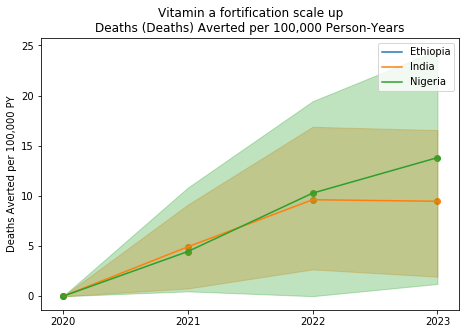

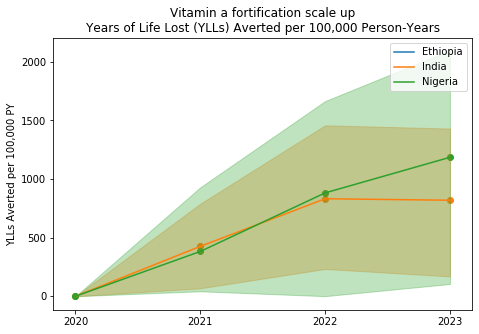

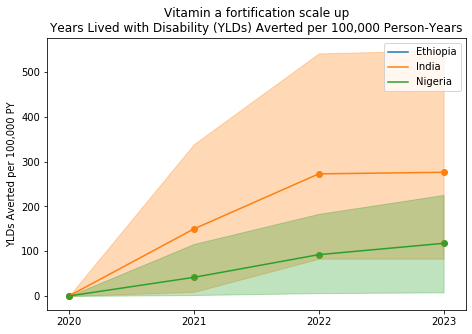

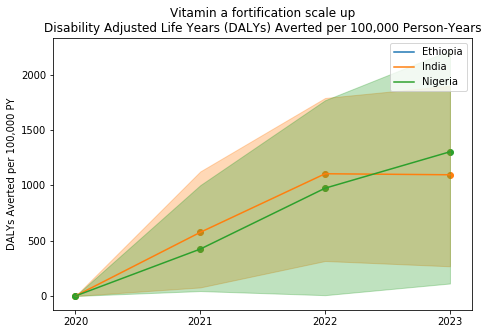

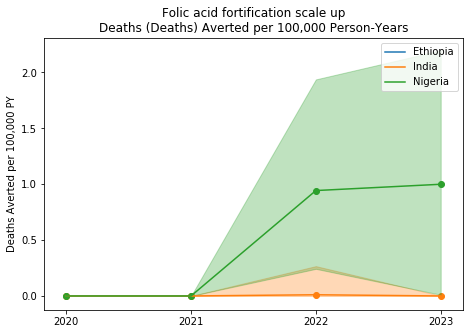

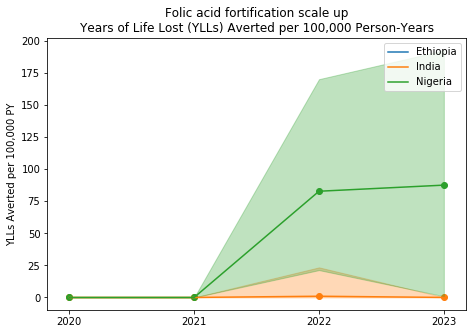

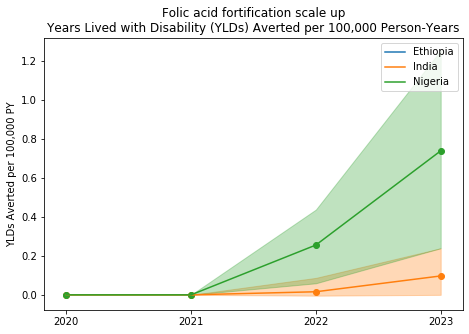

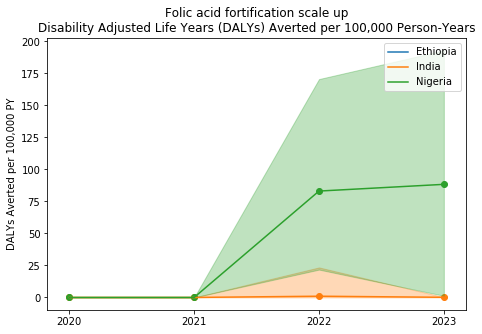

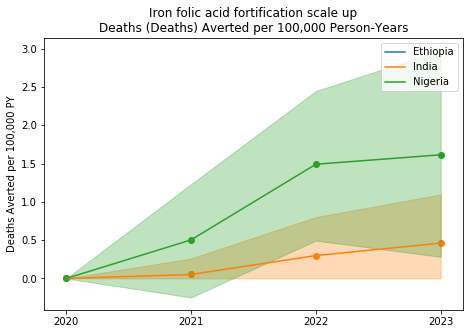

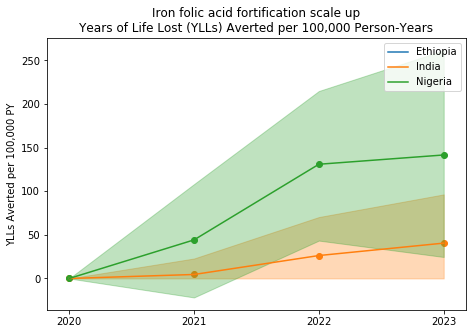

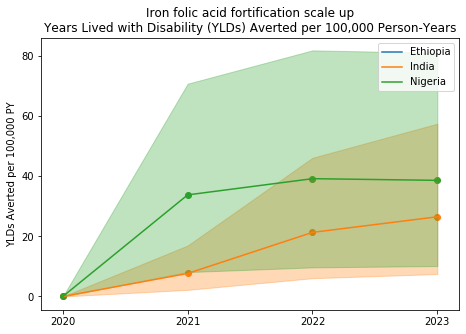

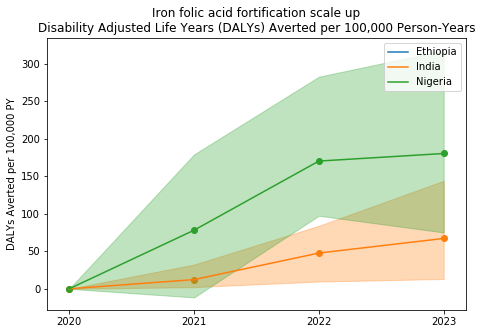

In [33]:
scenarios = ['vitamin_a_fortification_scale_up',
             'folic_acid_fortification_scale_up',
             'iron_folic_acid_fortification_scale_up']

outcome_vars = ['deaths','ylls','ylds','dalys']

make_multiple_plots_by_year_with_uncertainty(by_year, scenarios, outcome_vars)

In [34]:
def make_multiple_dot_plots(dataset, scenarios, outcome_vars):
    
    for scenario in scenarios:
        for outcome_var in outcome_vars:
    
            data = dataset.loc[dataset.scenario == scenario]
            if outcome_var == 'dalys':
                data = data.loc[data.measure.isin(['ylds','ylls'])]
                data = data.groupby(['location','input_draw']).sum()
            else:
                data = data.loc[data.measure == outcome_var]
            data = data.groupby(['location']).describe()
    
            if outcome_var == 'dalys':
                outcome_name_long = 'Disability Adjusted Life Years'
                outcome_name_short = 'DALYs'
            elif outcome_var == 'ylls':
                outcome_name_long = 'Years of Life Lost'
                outcome_name_short = 'YLLs'
            elif outcome_var == 'ylds':
                outcome_name_long = 'Years Lived with Disability'
                outcome_name_short = 'YLDs'
            else:
                outcome_name_long = 'Deaths'
                outcome_name_short = 'Deaths'
        
            pos1 = 0.2
            pos2 = 0.4
            pos3 = 0.6    
            
            fig, ax = plt.subplots(figsize=(7.5, 5))

            plt.plot([(pos1 - 0.1),(pos3 + 0.1)],[0,0],'--',c='grey')

            plt.plot([pos1,pos1],[data['value','min'][0],data['value','max'][0]],c='black')
            plt.plot([pos2,pos2],[data['value','min'][1],data['value','max'][1]],c='black')
            #plt.plot([pos3,pos3],[data['value','min'][2],data['value','max'][2]],c='black')
            #plt.scatter([pos1,pos2,pos3],data['value','min'], marker='_',c='black',s=50)
            #plt.scatter([pos1,pos2,pos3],data['value','max'], marker='_',c='black',s=50)         
            #plt.scatter([pos1,pos2,pos3],data['value','mean'], s=100)
            
            #rewritten for india and nigeria only
            plt.scatter([pos1,pos2],data['value','min'], marker='_',c='black',s=50)
            plt.scatter([pos1,pos2],data['value','max'], marker='_',c='black',s=50)         
            plt.scatter([pos1,pos2],data['value','mean'], s=100)
            
            scenario_title = scenario.replace('_',' ').capitalize()

            plt.xticks([pos1,pos2,pos3], data.index)
            if outcome_var == 'deaths':
                plt.title(f'{scenario_title}\n{outcome_name_long} Averted per 100,000 Person-Years')
            else:
                plt.title(f'{scenario_title}\n{outcome_name_long} ({outcome_name_short}) Averted per 100,000 Person-Years')
            plt.ylabel(f'{outcome_name_short} Averted per 100,000 PY')

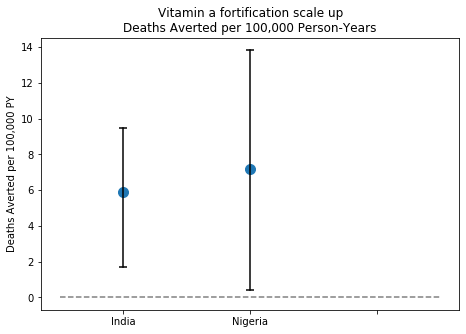

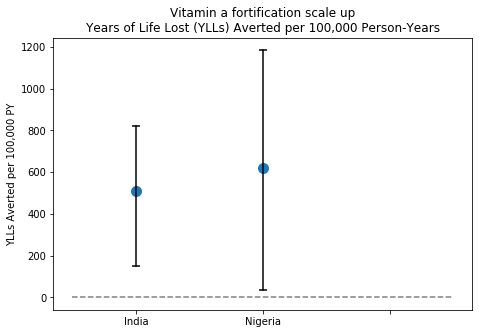

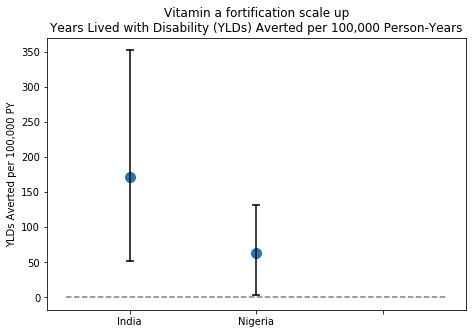

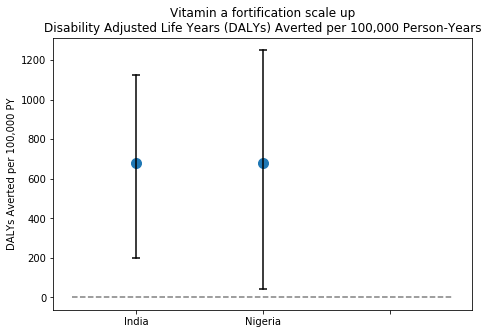

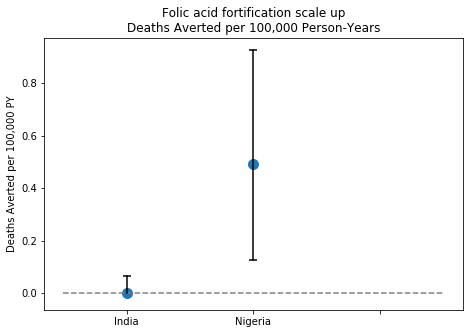

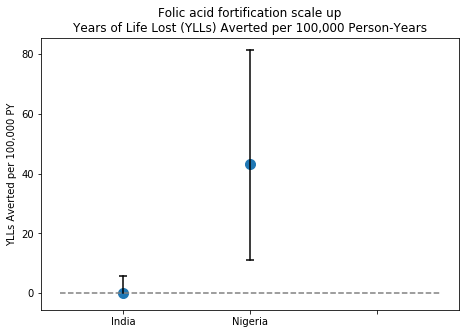

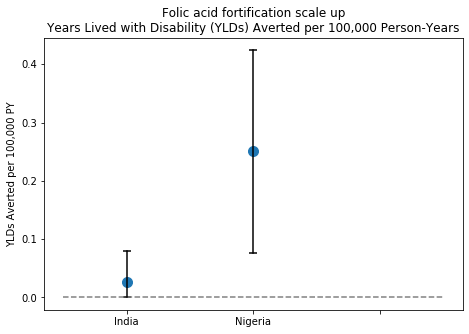

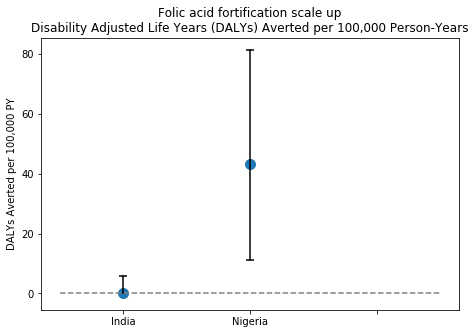

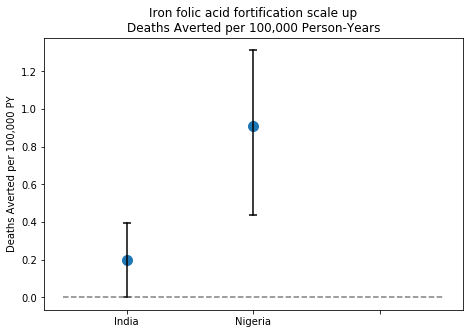

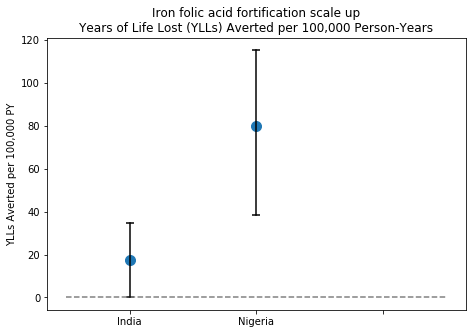

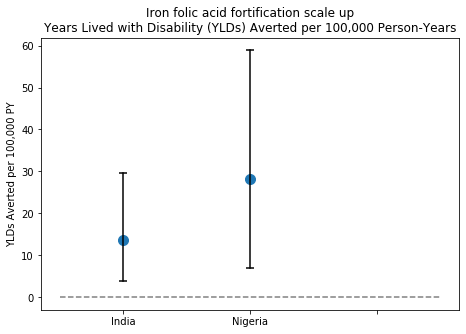

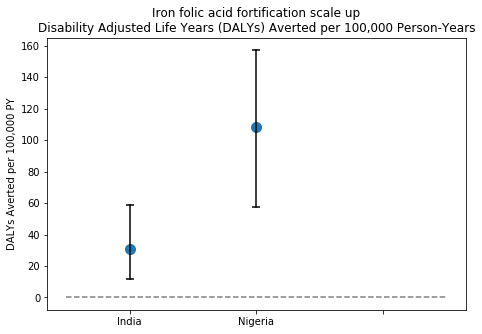

In [35]:
scenarios = ['vitamin_a_fortification_scale_up','folic_acid_fortification_scale_up',
            'iron_folic_acid_fortification_scale_up']

outcome_vars = ['deaths','ylls','ylds','dalys']

make_multiple_dot_plots(overall, scenarios, outcome_vars)